In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [88]:
# Read data
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

# Separate features and labels
X_train = (df_train.drop('label', axis=1).values / 255.0).T  # Shape: (784, #train_samples)
X_test = (df_test.drop('label', axis=1).values / 255.0).T    # Shape: (784, #test_samples)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=True)  # or sparse_output=False if you want a dense array directly
y_train = encoder.fit_transform(df_train[['label']]).toarray().T
y_test = encoder.transform(df_test[['label']]).toarray().T

In [89]:
# Activation functions

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    """
    Derivative of ReLU. Returns 1 where x > 0, else 0.
    """
    return (x > 0).astype(float)

def softmax(x):
    """
    Numerically stable softmax, applied column-wise.
    x.shape -> (n_neurons, m)
    Returns same shape.
    """
    # subtract max per column for numerical stability
    x_shifted = x - np.max(x, axis=0, keepdims=True)
    exps = np.exp(x_shifted)
    return exps / np.sum(exps, axis=0, keepdims=True)

In [90]:
# Loss functions

def cross_entropy_loss(y_true, y_pred):
    """
    Cross-entropy loss for one-hot y_true and probability y_pred.
    y_true.shape -> (num_classes, m)
    y_pred.shape -> (num_classes, m)
    """
    m = y_true.shape[1]
    # Clip to avoid log(0)
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
    return loss

def cross_entropy_derivative(y_true, y_pred):
    """
    Derivative of cross entropy wrt. the logits AFTER softmax is:
    dZ = (y_pred - y_true)
    (when combining softmax + cross-entropy).
    """
    return y_pred - y_true

In [91]:
class Layer:
    def __init__(self, n_inputs, n_neurons, activation=None):
        """
        n_inputs:  dimension of input to this layer
        n_neurons: number of neurons in this layer (its output dimension)
        activation: 'relu', 'softmax', or None
        """
        # Weight initialization: He initialization for ReLU, or some standard approach
        # For simplicity, let's do a scaled random normal:
        if activation == 'relu':
            # He initialization
            self.weights = np.random.randn(n_neurons, n_inputs) * np.sqrt(2.0 / n_inputs)
        else:
            # Generic small initialization
            self.weights = np.random.randn(n_neurons, n_inputs) * 0.01
        
        # Bias shape: (n_neurons, 1)
        self.biases = np.zeros((n_neurons, 1))
        
        # Activation function
        if activation is None:
            self.activation = lambda x: x
            self.activation_derivative = lambda x: np.ones_like(x)
        elif activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'softmax':
            self.activation = softmax
            # We'll handle final layer derivative specially in training
            self.activation_derivative = None  # Not used for final layer with cross-entropy
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        self.z = None   # Will store linear combination (weights @ input + biases)
        self.input = None
        self.output = None

    def forward(self, inputs):
        """
        inputs.shape -> (n_inputs, m)
        weights.shape -> (n_neurons, n_inputs)
        biases.shape -> (n_neurons, 1)
        """
        self.input = inputs
        self.z = np.dot(self.weights, inputs) + self.biases  # shape -> (n_neurons, m)
        self.output = self.activation(self.z)                # apply activation
        return self.output

    def backward(self, dA, learning_rate):
        """
        dA is the gradient of the loss wrt. this layer's output.
        We compute dZ, dW, dB, and pass dA_prev back to earlier layers.
        
        For hidden layers or if activation != softmax, we do:
            dZ = dA * relu_derivative(z)  etc.
        For the final layer with softmax + cross-entropy, 
            we often pass dZ = (y_pred - y_true) directly,
            so dA = dZ in that scenario.
        """
        m = self.input.shape[1]  # number of examples

        if self.activation_derivative is not None:
            # Typical case: ReLU or linear
            dZ = dA * self.activation_derivative(self.z)  # shape (n_neurons, m)
        else:
            # If we're in the final layer with softmax + cross-entropy, dA = dZ directly
            dZ = dA

        # Gradient wrt. weights
        dW = (1 / m) * np.dot(dZ, self.input.T)  # shape -> (n_neurons, n_inputs)
        # Gradient wrt. biases
        dB = (1 / m) * np.sum(dZ, axis=1, keepdims=True)  # shape -> (n_neurons, 1)

        # Gradient wrt. inputs (to pass back)
        dA_prev = np.dot(self.weights.T, dZ)  # shape -> (n_inputs, m)

        # Update parameters
        self.weights -= learning_rate * dW
        self.biases  -= learning_rate * dB

        return dA_prev

In [92]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.history = []

    def add_layer(self, n_neurons, activation=None, input_dim=None):
        """
        n_neurons: number of neurons in this layer
        activation: 'relu', 'softmax', or None
        input_dim: dimension of input to this layer (only for the first layer)
        """
        if len(self.layers) == 0:
            if input_dim is None:
                raise ValueError("Must specify input_dim for the first layer.")
            n_inputs = input_dim
        else:
            # n_inputs is output size of the previous layer
            n_inputs = self.layers[-1].weights.shape[0]
        
        layer = Layer(n_inputs, n_neurons, activation=activation)
        self.layers.append(layer)

    def forward(self, X):
        """
        Forward pass through all layers
        """
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, dA, learning_rate):
        """
        Backprop through all layers in reverse order
        dA is gradient of loss wrt. final layer output (or dZ if final layer).
        """
        for layer in reversed(self.layers):
            dA = layer.backward(dA, learning_rate)

    def train(self, X, Y, learning_rate=0.01, epochs=100, print_every=10):
        """
        X.shape -> (input_dim, m)
        Y.shape -> (num_classes, m)
        """
        for epoch in range(epochs):
            # Forward pass
            Y_pred = self.forward(X)
            
            # Compute loss
            loss = cross_entropy_loss(Y, Y_pred)
            
            # Compute gradient wrt final layer output
            # For softmax + cross-entropy, dZ = (y_pred - y_true)
            dZ_final = cross_entropy_derivative(Y, Y_pred)
            
            # Backward pass
            self.backward(dZ_final, learning_rate)
            
            if epoch % print_every == 0:
                self.history.append((epoch, loss))
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        """
        Return class predictions given input X.
        """
        Y_pred = self.forward(X)  # shape -> (num_classes, m)
        return np.argmax(Y_pred, axis=0)

    def evaluate(self, X, Y):
        """
        Computes accuracy: fraction of correctly classified samples.
        Y is one-hot; we compare argmax(Y_pred) to argmax(Y).
        """
        Y_pred = self.forward(X)
        predictions = np.argmax(Y_pred, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels) * 100
        return accuracy

In [93]:
# Create the network
nn = NeuralNetwork()
nn.add_layer(n_neurons=128, activation='relu', input_dim=X_train.shape[0])  # input_dim=784 for MNIST
nn.add_layer(n_neurons=64, activation='relu')
nn.add_layer(n_neurons=10, activation='softmax')

# Train the network
nn.train(X_train, y_train, learning_rate=0.5, epochs=200, print_every=10)

# Evaluate on test data
test_accuracy = nn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch 0/200, Loss: 2.3030
Epoch 10/200, Loss: 1.5593
Epoch 20/200, Loss: 1.6053
Epoch 30/200, Loss: 0.7925
Epoch 40/200, Loss: 0.5774
Epoch 50/200, Loss: 0.5601
Epoch 60/200, Loss: 0.3568
Epoch 70/200, Loss: 0.4052
Epoch 80/200, Loss: 0.2995
Epoch 90/200, Loss: 0.2764
Epoch 100/200, Loss: 0.2691
Epoch 110/200, Loss: 0.3217
Epoch 120/200, Loss: 0.2344
Epoch 130/200, Loss: 0.2261
Epoch 140/200, Loss: 0.2315
Epoch 150/200, Loss: 0.2082
Epoch 160/200, Loss: 0.1949
Epoch 170/200, Loss: 0.1876
Epoch 180/200, Loss: 0.1812
Epoch 190/200, Loss: 0.1753
Test Accuracy: 94.89%


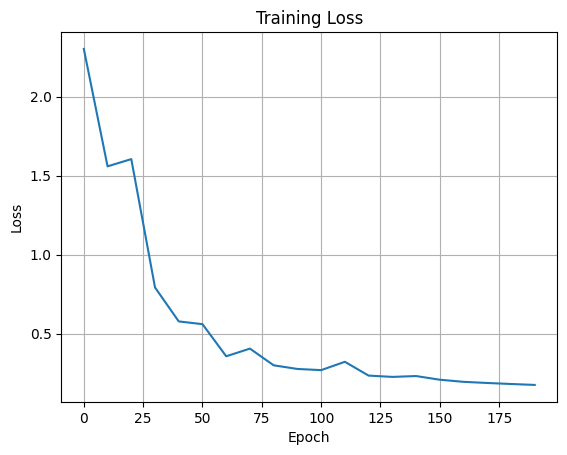

In [94]:
nn_history = np.array(nn.history)
plt.plot(nn_history[:, 0], nn_history[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()


In [95]:
def display_predictions(nn, X, y, num_images=10):
    """
    Displays a specified number of MNIST test images along with their true and predicted labels.

    Parameters:
    - nn: Trained NeuralNetwork instance.
    - X: Input features, shape (784, num_samples).
    - y: True labels in one-hot encoding, shape (10, num_samples).
    - num_images: Number of images to display.

    Returns:
    - None
    """
    # Get predictions from the network
    predictions = nn.predict(X)  # Shape: (num_samples,)

    # Convert one-hot encoded labels to integers
    true_labels = np.argmax(y, axis=0)  # Shape: (num_samples,)

    # Select random indices for visualization
    num_samples = X.shape[1]
    if num_images > num_samples:
        num_images = num_samples
    random_indices = np.random.choice(num_samples, num_images, replace=False)

    # Determine grid size for plotting
    grid_cols = 5
    grid_rows = num_images // grid_cols + int(num_images % grid_cols != 0)

    plt.figure(figsize=(grid_cols * 2, grid_rows * 2))

    for i, idx in enumerate(random_indices):
        # Retrieve image and labels
        image = X[:, idx].reshape(28, 28)  # Reshape to 28x28
        true_label = true_labels[idx]
        pred_label = predictions[idx]

        # Plot image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

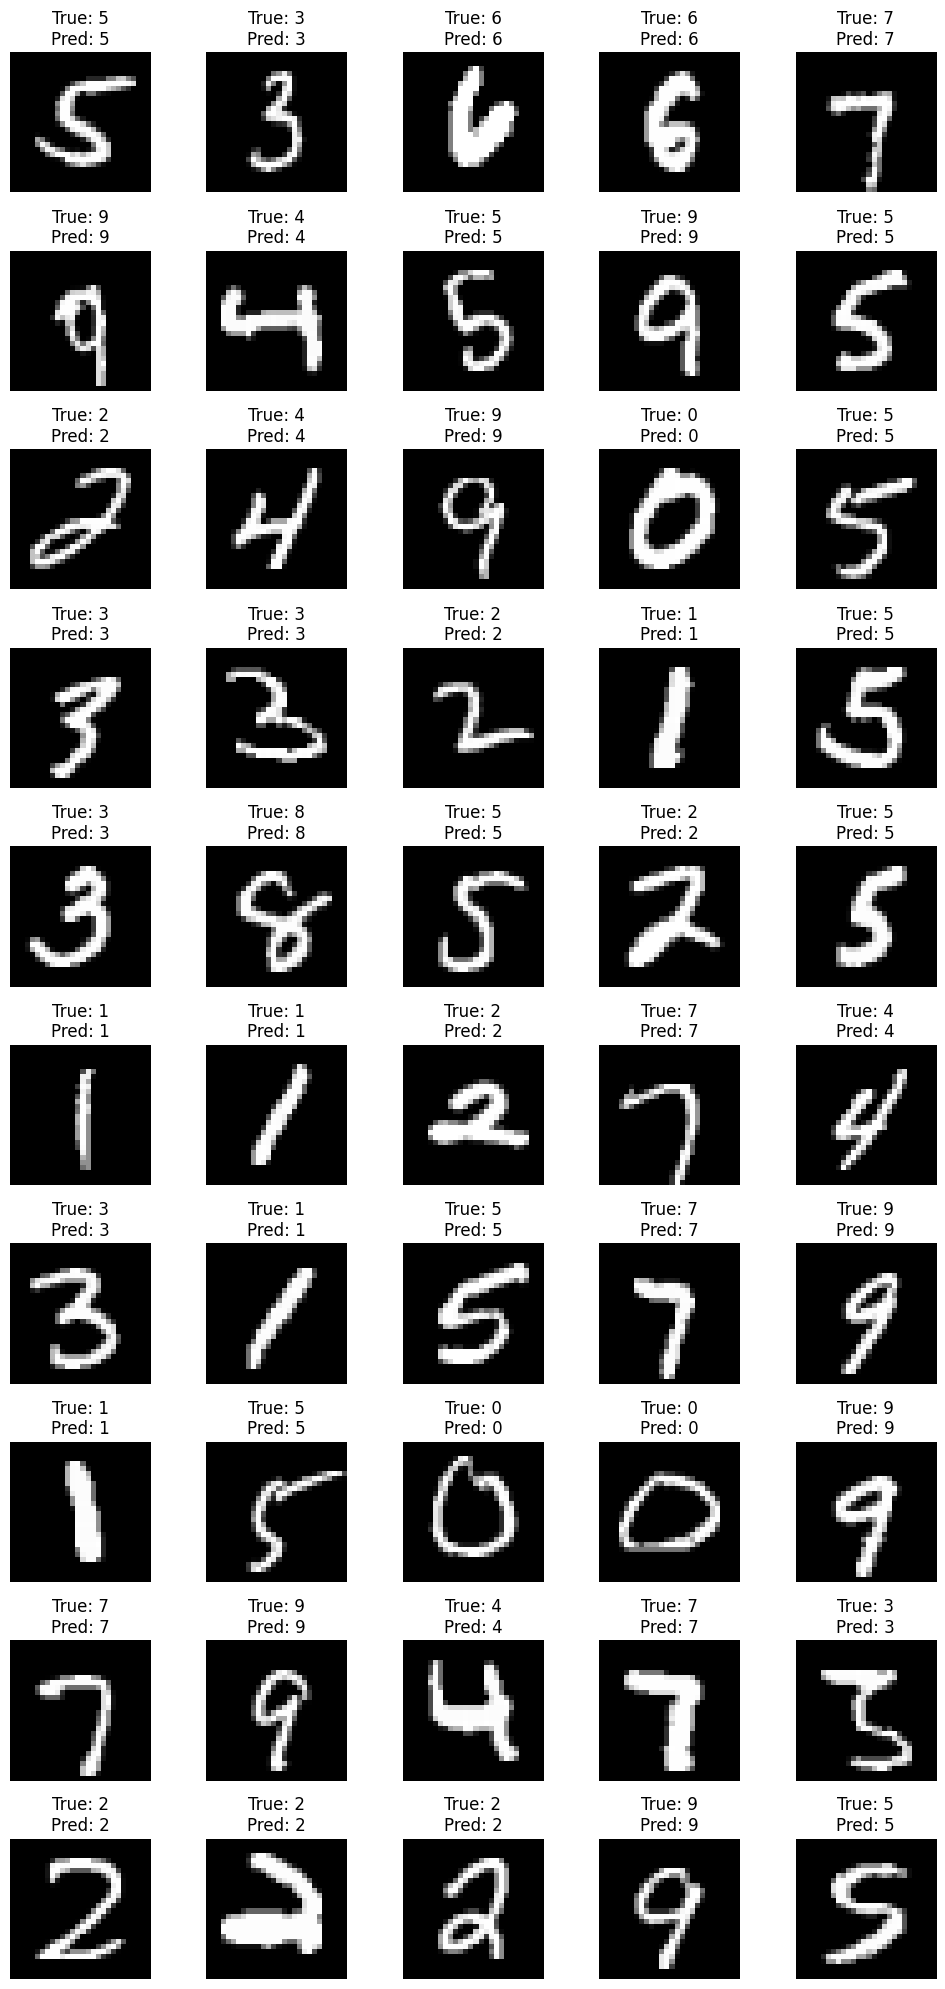

In [96]:
display_predictions(nn, X_test, y_test, num_images=50)